In [77]:
%matplotlib ipympl

In [2]:
import cv2
import pickle
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from skspatial.objects import Plane, Points
from skspatial.plotting import plot_3d
import glob

In [3]:
path_current = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.split(path_current)[0])

from app_sys import AppSys
from utils_predict import standardize_fsize_coord_conversion, standardize_fsize
from utils import Holds, WallKeypoints

from humanpose.pose3d import Body
from humanpose.keypoints import get_edge_coords_all

app_sys = AppSys()

In [4]:
# t = 0
t = 100
# t = 550

# 1. Load kp coords

The coordinates recorded on tkinter canvas for squared (640x640) image

In [5]:
direc = os.path.join(app_sys.PATH_ASSET, 'concept_test')

In [6]:
direc_img = pickle.load(open(os.path.join(direc,'img0.pkl'), 'rb'))
kp = pickle.load(open(os.path.join(direc,'kp0.pkl'), 'rb'))

In [7]:
print(direc_img)
direc_img_depth = direc_img.replace('original', 'depth')
print(direc_img_depth)

/workspaces/MoonClimbers/app/asset/prep_kp/temp/1StarChoss_trimmed_masked_0_original.jpg
/workspaces/MoonClimbers/app/asset/prep_kp/temp/1StarChoss_trimmed_masked_0_depth.jpg


# 2. Depth information

In [8]:
depth_array = np.load(os.path.join(app_sys.PATH_ASSET_DEPTH, '1StarChoss_trimmed_depths.npz'))
depth_array

NpzFile '/workspaces/MoonClimbers/app/asset/depth/1StarChoss_trimmed_depths.npz' with keys: depths

frame numbers, height, width

In [9]:
depth = depth_array['depths']

In [10]:
nt, ny, nx = depth.shape

The closer the larger the values -> the inverse distance is recorded

# 3. KP coordinates conversion from the square frame to the original frame

## Coordinates of the KPs on the square frame

In [11]:
df_sq = pd.DataFrame(index=kp.get_node_names(), columns=['X', 'Y', 'Z'])
df_sq = df_sq.astype(float)
for key in df_sq.index:
    df_sq.loc[key, ['X', 'Y']] = kp.get_node_coords(key)

## Coordinates of the KPs on the original video frames

In [12]:
video = cv2.VideoCapture('/workspaces/MoonClimbers/app/asset/depth/1StarChoss_trimmed_vis.mp4')
video.set(cv2.CAP_PROP_POS_FRAMES, t)
res, frame = video.read()

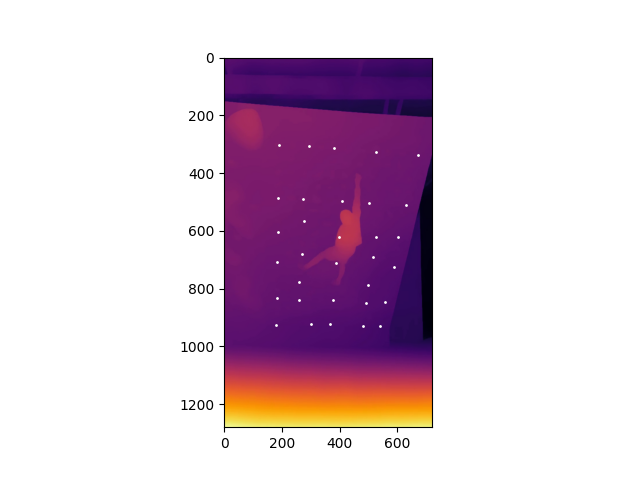

In [13]:
fig, ax = plt.subplots()
frame_depth = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
ax.imshow(frame_depth)

df = df_sq.copy()
# DF of the depth value
for k in df_sq.index:
    xx, yy = df_sq.loc[k, ['X', 'Y']]
    # Coordinates before reshaping the frame to 640x640
    x, y = standardize_fsize_coord_conversion(os.path.join(app_sys.PATH_ASSET_DEPTH, '1StarChoss_trimmed_vis.mp4'), 640, (xx/500*640,yy/500*640))
    # ax.scatter(int(x), int(y), facecolors='none', color='white')
    ax.scatter(int(x), int(y), color='white', s=1)
    # values need to be inverted as they are likely inverse depth for visualisation purpose
    z = 1/(depth[t,y,x] + 1e-9) * 1000
    df.loc[k, ['X', 'Y', 'Z']] = (x,y,z)


# 4. 3D visualisation of the KPs

For most smartphone cameras, the principal point is near the center of the image:

In [14]:
def get_camera_matrix(direc_cariburation_imgs):
    # Define checkerboard properties
    CHECKERBOARD = (9, 6)  # (internal corners per row, per column)
    square_size = 0.015  # Set the square size in meters (e.g., 2.5cm = 0.025m)

    # Arrays to store object points and image points
    objpoints = []  # 3D world points
    imgpoints = []  # 2D image points

    # Define real-world 3D points for the checkerboard
    objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2) * square_size

    # Load all images from folder
    images = glob.glob(direc_cariburation_imgs + '/camera_calibration/*.JPG')

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Detect checkerboard corners
        ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)
        
        if ret:
            print(f"✅ Pattern detected in {fname}")
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, CHECKERBOARD, corners, ret)
        else:
            print(f"❌ Pattern NOT detected in {fname}")

    # Camera calibration
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    # Print results
    print("\nCamera Matrix (K):\n", K)
    fx, fy = K[0,0], K[1,1]
    cx, cy = K[:2,2]
    print(f'fx, fy: {fx, fy}px\ncx, cy: {cx, cy}px')
    print("\nDistortion Coefficients (D):\n", dist)
    return K, dist


In [15]:
K, dist = get_camera_matrix(direc)

✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220112594LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220030216LS.JPG
❌ Pattern NOT detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220057089LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220114955LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220019763LS.JPG
❌ Pattern NOT detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220059527LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220016416LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220103774LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220046168

# 9. Human pose estimation (3D)

In [16]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
body = Body(t)
# body.plot(ax)
# plt.show()

# 10. Solve PnP to standardize the viewpoint

In [49]:
def solvePnP(world_coords, img_coords, vervose=False):
    """
    PnP solver for the wall and human pose
    """
    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        world_coords,
        img_coords,
        K,
        dist,
        flags=cv2.SOLVEPNP_ITERATIVE,
        reprojectionError=8.0,
        confidence=0.99
    )

    if success:
        if vervose:
            print("Rotation Vector:\n", rvec)
            print("Translation Vector:\n", tvec)
        return rvec, tvec
    else:
        print("PnP RANSAC failed.")
        return None, None

In [18]:
def get_wrld_coords_wall():
    kps = WallKeypoints('example', inverty=True)
    coords_3d = kps.get_node_coords_all_3d()
    world_coords_wall = []
    for key in kps.get_node_names():
        world_coords_wall.append(coords_3d[key])
    return np.array(world_coords_wall).astype('float32')

In [19]:
def get_img_coords_wall(df):
    kps = WallKeypoints('example', inverty=True)
    img_coords_wall = []
    for key in kps.get_node_names():
        img_coords_wall.append(tuple(df.loc[key,['X', 'Y']]))
    return np.array(img_coords_wall).astype('float32')

In [20]:
img_coords_wall = get_img_coords_wall(df)
world_coords_wall = get_wrld_coords_wall()

In [21]:
rvec_wall, tvec_wall = solvePnP(world_coords_wall, img_coords_wall)

Rotation Vector:
 [[     1.4849]
 [   -0.19346]
 [    0.17173]]
Translation Vector:
 [[    -1080.9]
 [    -119.84]
 [     8175.1]]


In [22]:
def get_extrinsic_matrix(rvec, tvec):
    """
    Extrinsic matrix
    """
    T = np.eye(4)
    R, _ = cv2.Rodrigues(rvec)
    T[:3, :3] = R
    T[:3, 3] = tvec.flatten()
    return T

In [23]:
# Extrinsic matrix
T_wall = get_extrinsic_matrix(rvec_wall, tvec_wall)
T_wall_inv = get_extrinsic_matrix(-rvec_wall, -tvec_wall)

Map the 3D point to 2D point 

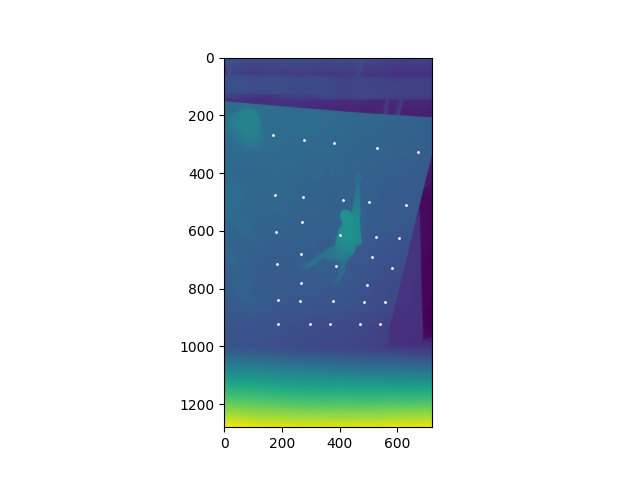

In [24]:
# Map the 3D point to 2D point 
points_2d, _ = cv2.projectPoints(world_coords_wall, 
                                 rvec_wall, tvec_wall, 
                                 K, 
                                 dist) 
fig, ax = plt.subplots()
ax.imshow(depth[t,:,:])
for coords in points_2d:
    xx, yy = coords[0]
    ax.scatter(xx, yy, c='white', s=1)

In [25]:
# Instance that consists of all the holds info
kwargs = {
    'inverty': True,
    'rvec': rvec_wall,
    'tvec': tvec_wall, 
    'K': K, 
    'dist': dist

}
holds = Holds(**kwargs)

Solve PnP for human pose

- Assuming that the MediaPipe 3D coords are absolute coordinates.
- Try to match the perspective in the frame.

In [26]:
def get_wrld_coords_pose(t):
    world_coords_pose = []
    for c0, c1, c2 in body.coords3d[t]:
        world_coords_pose.append([c0 * 1e3, c1 * 1e3, c2 * 1e3])
    return np.array(world_coords_pose).astype('float32')

In [27]:
def get_img_coords_pose(t):
    df_pose2d = pd.DataFrame(columns=['X','Y'])
    df_pose2d['X'] = np.array(body.coords2d[t][:,0])*nx
    df_pose2d['Y'] = np.array(body.coords2d[t][:,1])*ny
    img_coords_pose = []
    for i in df_pose2d.index:
        img_coords_pose.append(list(df_pose2d.loc[i,['X', 'Y']]))
    return np.array(img_coords_pose).astype('float32')

In [28]:
world_coords_pose = get_wrld_coords_pose(t)
img_coords_pose = get_img_coords_pose(t)

In [29]:
rvec_pose, tvec_pose = solvePnP(world_coords_pose, img_coords_pose)

Rotation Vector:
 [[    0.38761]
 [   -0.32884]
 [  -0.037215]]
Translation Vector:
 [[    -584.25]
 [    -1352.7]
 [     6437.3]]


In [30]:
# Map the 3D point to 2D point 
pose_2d, _ = cv2.projectPoints(world_coords_pose, 
                                 rvec_pose, tvec_pose, 
                                 K, 
                                 dist)

edge_2d = []
for k, v in get_edge_coords_all(world_coords_pose).items():
    p0, p1 = v
    p0_projection, _ = cv2.projectPoints(p0, rvec_pose, tvec_pose, K, dist)
    p1_projection, _ = cv2.projectPoints(p1, rvec_pose, tvec_pose, K, dist)
    edge_2d.append([p0_projection[0][0], p1_projection[0][0]])
edge_2d = np.array(edge_2d)

wall_2d, _ = cv2.projectPoints(world_coords_wall, 
                                 rvec_wall, tvec_wall, 
                                 K, 
                                 dist)


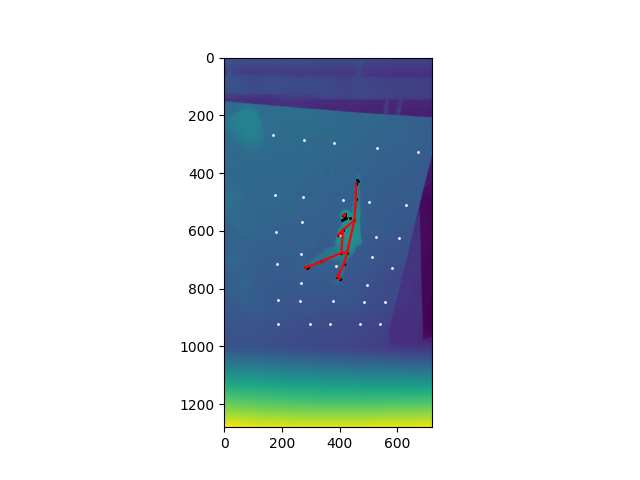

In [31]:
fig, ax = plt.subplots()
ax.invert_yaxis()
ax.imshow(depth[t,:,:])
for coords in pose_2d:
    xx, yy = coords[0]
    ax.scatter(xx, yy, c='black', s=1.5)

for coords in wall_2d:
    xx, yy = coords[0]
    ax.scatter(xx, yy, c='white', s=1)

for p0, p1 in edge_2d:
    ax.plot([p0[0], p1[0]], [p0[1], p1[1]], c='red')

In [32]:
# Extrinsic matrix
T_pose = get_extrinsic_matrix(rvec_pose, tvec_pose)

In [33]:
def local2global_coords(T_pose, T_wall_inv, world_coords_pose):
    """
    Convert the 3D human pose coordinates around the hip to global coordinates
    rvec_wall, tvec_wall: rotation & translation vectors obtained by solving PnP for the wall    
    world_coords_pose: 3D coordinates of the human pose in the video frame pov
    
    """

    converted = []
    for x3d, y3d, z3d in world_coords_pose:
        # MediaPipe pov to frame pov
        xx, yy, zz, _ = T_pose@[x3d,y3d,z3d,1]
        # xxx, yyy, zzz, _ = T_wall_inv@[xx,yy,zz,1]
        converted.append([xx, yy, zz])
        # converted.append([xxx, yyy, zzz])
    return np.array(converted)

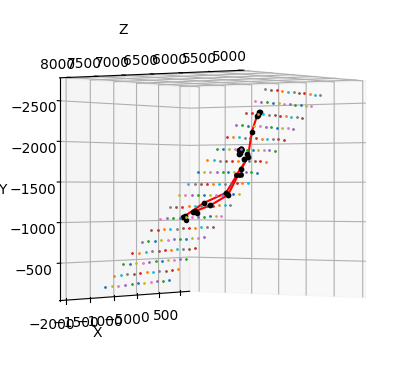

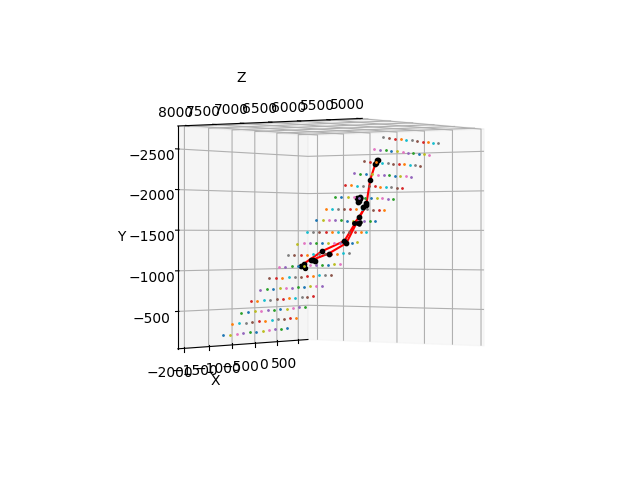

In [34]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_aspect('equal')



coords_pose = local2global_coords(T_pose, T_wall_inv, world_coords_pose)
for e, (x, y, z) in enumerate(coords_pose):
    ax.scatter(x, y, z, c='black', s=np.array(body.coords3d_conf)[t,e]*10)

for k, v in get_edge_coords_all(coords_pose).items():
    p0, p1 = v
    ax.plot([p0[0], p1[0]], [p0[1], p1[1]], [p0[2], p1[2]], c='red')


for k, v in holds.coords_world.items():
    xx, yy, zz, _ = T_wall @ [v[0], v[1], v[2], 1]
    # xxx, yyy, zzz, _ = T_wall_inv @ [xx, yy, zz, 1]
    # ax.scatter(xxx, yyy, zzz, label=k, s=1)
    ax.scatter(xx, yy, zz, label=k, s=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.view_init(elev=4, azim=0, roll=-82)
ax.view_init(elev=-35, azim=180, roll=90)
fig

In [ ]:
direc = os.path.join(app_sys.PATH_ASSET, 'concept_test')
direc_img = pickle.load(open(os.path.join(direc,'img0.pkl'), 'rb'))
kp = pickle.load(open(os.path.join(direc,'kp0.pkl'), 'rb'))
print(direc_img)
direc_img_depth = direc_img.replace('original', 'depth')
print(direc_img_depth)
depth_array = np.load(os.path.join(app_sys.PATH_ASSET_DEPTH, '1StarChoss_trimmed_depths.npz'))
depth = depth_array['depths']
nt, ny, nx = depth.shape

video = cv2.VideoCapture('/workspaces/MoonClimbers/app/asset/depth/1StarChoss_trimmed_vis.mp4')

/workspaces/MoonClimbers/app/asset/prep_kp/temp/1StarChoss_trimmed_masked_0_original.jpg
/workspaces/MoonClimbers/app/asset/prep_kp/temp/1StarChoss_trimmed_masked_0_depth.jpg


In [42]:
K, dist = get_camera_matrix(direc)

✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220112594LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220030216LS.JPG
❌ Pattern NOT detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220057089LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220114955LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220019763LS.JPG
❌ Pattern NOT detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220059527LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220016416LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220103774LS.JPG
✅ Pattern detected in /workspaces/MoonClimbers/app/asset/concept_test/camera_calibration/250329220046168

In [43]:
t = 60
vervose = False

In [45]:
def reconstruct_3d(t, video, kp, depth, K, dist, vervose=False, plot=False):
    video.set(cv2.CAP_PROP_POS_FRAMES, t)
    res, frame = video.read()

    df_sq = pd.DataFrame(index=kp.get_node_names(), columns=['X', 'Y', 'Z'])
    df_sq = df_sq.astype(float)
    for key in df_sq.index:
        df_sq.loc[key, ['X', 'Y']] = kp.get_node_coords(key)

    df = df_sq.copy()
    # DF of the depth value
    for k in df_sq.index:
        xx, yy = df_sq.loc[k, ['X', 'Y']]
        # Coordinates before reshaping the frame to 640x640
        x, y = standardize_fsize_coord_conversion(os.path.join(app_sys.PATH_ASSET_DEPTH, '1StarChoss_trimmed_vis.mp4'), 640, (xx/500*640,yy/500*640))
        # values need to be inverted as they are likely inverse depth for visualisation purpose
        z = 1/(depth[t,y,x] + 1e-9) * 1000
        df.loc[k, ['X', 'Y', 'Z']] = (x,y,z)

    body = Body(t)

    img_coords_wall = get_img_coords_wall(df)
    world_coords_wall = get_wrld_coords_wall()
    world_coords_pose = get_wrld_coords_pose(t)
    img_coords_pose = get_img_coords_pose(t)

    rvec_wall, tvec_wall = solvePnP(world_coords_wall, img_coords_wall)
    rvec_pose, tvec_pose = solvePnP(world_coords_pose, img_coords_pose)

    # Extrinsic matrix
    T_wall = get_extrinsic_matrix(rvec_wall, tvec_wall)
    T_wall_inv = get_extrinsic_matrix(-rvec_wall, -tvec_wall)
    T_pose = get_extrinsic_matrix(rvec_pose, tvec_pose)

    """
    3D to 2D Projection
    """
    if vervose:
        pose_2d, _ = cv2.projectPoints(world_coords_pose, 
                                        rvec_pose, tvec_pose, 
                                        K, 
                                        dist)

        edge_2d = []
        for k, v in get_edge_coords_all(world_coords_pose).items():
            p0, p1 = v
            p0_projection, _ = cv2.projectPoints(p0, rvec_pose, tvec_pose, K, dist)
            p1_projection, _ = cv2.projectPoints(p1, rvec_pose, tvec_pose, K, dist)
            edge_2d.append([p0_projection[0][0], p1_projection[0][0]])
        edge_2d = np.array(edge_2d)

        wall_2d, _ = cv2.projectPoints(world_coords_wall, 
                                        rvec_wall, tvec_wall, 
                                        K, 
                                        dist)

        fig, ax = plt.subplots()
        ax.invert_yaxis()
        ax.imshow(depth[t,:,:])
        for coords in pose_2d:
            xx, yy = coords[0]
            ax.scatter(xx, yy, c='black', s=1.5)

        for coords in wall_2d:
            xx, yy = coords[0]
            ax.scatter(xx, yy, c='white', s=1)

        for p0, p1 in edge_2d:
            ax.plot([p0[0], p1[0]], [p0[1], p1[1]], c='red')

    """
    3D wall + 3D human pose
    """
    if plot:
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.set_aspect('equal')

    coords_pose = local2global_coords(T_pose, T_wall_inv, world_coords_pose)

    if plot:
        for e, (x, y, z) in enumerate(coords_pose):
            ax.scatter(x, y, z, c='black', s=np.array(body.coords3d_conf)[t,e]*10)

        for k, v in get_edge_coords_all(coords_pose).items():
            p0, p1 = v
            ax.plot([p0[0], p1[0]], [p0[1], p1[1]], [p0[2], p1[2]], c='red')

    coords_wall = []
    for k, v in holds.coords_world.items():
        xx, yy, zz, _ = T_wall @ [v[0], v[1], v[2], 1]
        # xxx, yyy, zzz, _ = T_wall_inv @ [xx, yy, zz, 1]
        coords_wall.append([xx, yy, zz])
        if plot:
            # ax.scatter(xxx, yyy, zzz, label=k, s=1)
            ax.scatter(xx, yy, zz, label=k, s=1)

    if plot:
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        # ax.view_init(elev=4, azim=0, roll=-82)
        ax.view_init(elev=-35, azim=180, roll=90)
    return coords_pose, np.array(coords_wall)

In [53]:
import matplotlib.animation as animation

In [78]:
from IPython.display import HTML

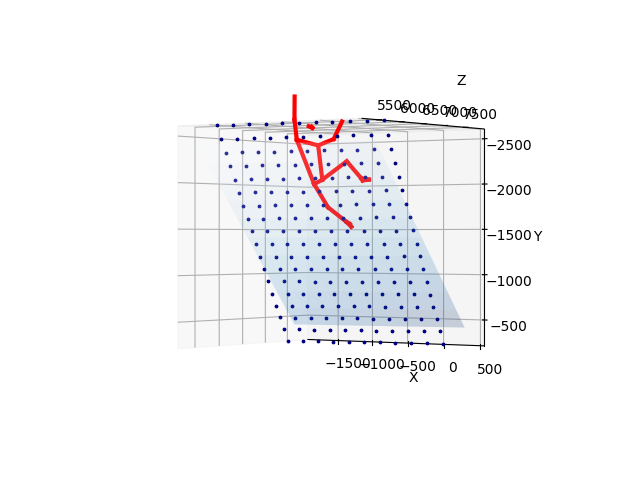

In [153]:
poses, walls = [], []
# for t in [0, 200, 400, 600]:
for t in np.linspace(0,600,301).astype(int):
    p, w = reconstruct_3d(t, video, kp, depth, K, dist, vervose=False, plot=False)
    poses.append(p)
    walls.append(w)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_aspect('equal')

wall = walls[0]
for x, y, z in wall:
    ax.scatter(x, y, z, s=3, c='navy')

xmax, ymax, zmax = np.max(wall, axis=0)
xmin, ymin, zmin = np.min(wall, axis=0)

points = Points(wall)
plane = Plane.best_fit(points)

a, b, c, d = plane.cartesian()

# Create the mesh in polar coordinates and compute corresponding Z.
x = np.linspace(xmin+200, xmax-200, 11)
y = np.linspace(ymin+200, ymax-200, 11)
X, Y = np.meshgrid(x, y)
Z = -(a*X + b*Y + d) / c

# Plot the surface.
ax.plot_surface(X, Y, Z, cmap=plt.cm.Blues, alpha=0.2)




for pose in poses:
    # for x, y, z in pose:
        # ax.scatter(x,y, z, c='black', s=1)
    for k, v in get_edge_coords_all(pose).items():
        p0, p1 = v
        # ax.plot([p0[0], p1[0]], [p0[1], p1[1]], [p0[2], p1[2]], c='red')



edges_t = [list(get_edge_coords_all(pose).values()) for pose in poses]
ax.set(xlim3d=(xmin, xmax), xlabel='X')
ax.set(ylim3d=(ymin, ymax), ylabel='Y')
ax.set(zlim3d=(zmin, zmax), zlabel='Z')

# Just get the number of edges in one frame (assuming consistent number across frames)
n_edges = len(edges_t[0])

# Initialize N empty 3D lines
lines = []
for _ in range(n_edges):
    line, = ax.plot([], [], [], c='red', lw=3)  # one line for each edge
    lines.append(line)

def update_lines(frame_idx, edges_t, lines):
    edges = edges_t[frame_idx]  # only current frame's edges

    for i, (p0, p1) in enumerate(edges):
        x_vals = [p0[0], p1[0]]
        y_vals = [p0[1], p1[1]]
        z_vals = [p0[2], p1[2]]
        lines[i].set_data(x_vals, y_vals)
        lines[i].set_3d_properties(z_vals)
    
    ax.view_init(elev=-50 - frame_idx * 0.25, azim=180, roll=90)
    # ax.view_init(elev=-90, azim=180, roll=90)

    return lines


ani = animation.FuncAnimation(fig, update_lines,
                              frames=len(edges_t),
                              fargs=(edges_t, lines),
                              interval=10000, blit=False)
HTML(ani.to_jshtml())

writervideo = animation.FFMpegWriter(fps=60)
ani.save('3D_model.mp4', writer=writervideo) 